In [1]:
!pip install transformers
!pip install infelct
!pip install git+https://github.com/DeepTrackAI/deeplay

# MNIST digits generation from text with DDPM

We'll build a text-to-image denoising diffusion probabilistic model (DDPM) to generate hand-written digits from 

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We will download the dataset from the `torchvision` package of PyTorch. 

Before downloading the dataset, we will define the normalization that we will apply to the dataset through `torchvision.transforms` module. We will normalize the images to have pixel values between -1 and 1, which is a common practice for training ddpm models.

In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5], inplace=True), # Normalize all images to [-1, 1]
])

We will apply the transforms created above to the training and test MNIST datasets.

The training and test datasets will be downloaded from the `torchvision.datasets` module, into the directory specified by the `root` argument. The `train` argument specifies whether to download the training or the test dataset by setting it to `True` or `False` respectively. Here, we will download the training dataset.

The `transform` argument specifies the transforms to be applied to the dataset. We will pass the transforms created above to this argument.

Set the `download` argument to `True` to download the dataset.

In [3]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=transform, download=True)
valset = MNIST(root="data", train=False, transform=transform, download=True)

We can now visualize some images from the training dataset using the `matplotlib` package.

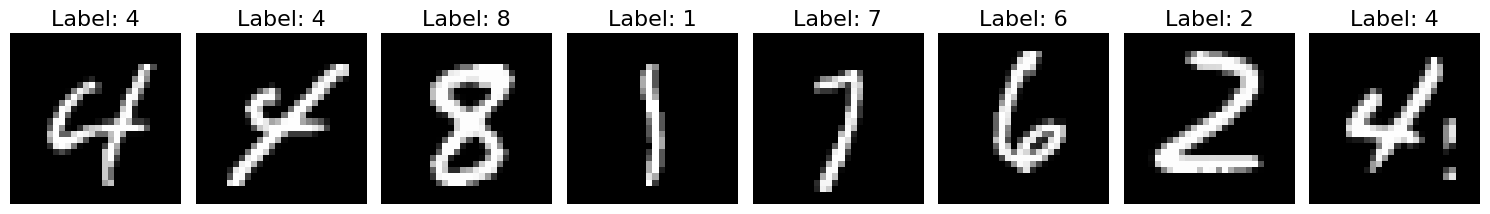

In [4]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
	img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()] # randomly select an image from the training set
	ax.imshow(img.squeeze(), cmap="gray")
	ax.set_title(f"Label: {label}", fontsize=16)
	ax.axis("off")
plt.tight_layout()
plt.show()

We now define the `device` to be used for training the model. We will use the GPU if it's available, otherwise we will use the CPU. The `torch.cuda.is_available()` function returns `True` if the GPU is available, otherwise it returns `False`.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
print(device)

cuda


## Diffusion process

In this section we will implement the forward and the reverse diffusion processes by defining the `Diffusion` class.

We define the `Diffusion` class with the following methods:
1. `prepare_noise_schedule`: Prepares the noise schedule based on the given `beta_start` and `beta_end` parameters, and the number of steps given by the parameter `noise_steps`.
2. `noise_images`: Implements the forward diffusion process. Given an input image `x`, and the time step `t`, it returns the noisy image `x_t`.
3. `sample_timesteps`: Generates `n` random time steps. This is used during the training process to generate a batch of random time steps for the forward diffusion process.
4. `sample_test_image`: Implements the reverse diffusion process. Generates an image from pure noise.

We will add additional attribute, `context`, to the `sample_test_image` method. This will allow us to generate images from textual inputs. The `context` attribute will take the context embedding of the input text. We will look at more details on the context embeddings in the next section.

In [7]:
from tqdm import tqdm

class Diffusion:
    def __init__(
        self,
        noise_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        img_size=256,
        device="cuda:0" if torch.cuda.is_available() else "cpu",
    ):
        """
        Parameters
        ----------
        noise_steps : int, optional
                Number of steps in the diffusion process, by default 1000
        beta_start : float, optional
                Starting value of the variance schedule $\beta_t$, by default 1e-4
        beta_end : float, optional
                Ending value of the variance schedule $\beta_t$, by default 0.02
        img_size : int, optional
                Size of the image, by default 256
		device : str, optional
			Device to use for the computations, by default "cuda:0" if torch.cuda.is_available() else "cpu"
        """
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(
            device
        )  # This will create a list of betas from beta_start to beta_end using the prepare_noise_schedule function
        self.alpha = 1.0 - self.beta  # This will create the list of alphas
        self.alpha_bar = torch.cumprod(
            self.alpha, dim=0
        )  # This will create a list of alpha_bars

    def prepare_noise_schedule(self):
        return torch.linspace(
            self.beta_start, self.beta_end, self.noise_steps
        )  # linear schedule

    def noise_images(self, x, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[
            :, None, None, None
        ]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,)).to(self.device)

    def sample_test_images(
        self,
        model,
        n,  # Number of images to sample
        n_channels,  # Number of channels in the image
        position_encoding_dim, # Dimension of the positional encoding
        position_encoding_function, # Positional encoding function
        fixed_noise=None,
        save_time_steps=None,
        save_every=200,  # Store the denoised images every "save_every" steps
        class_labels=None,
        cfg=False,
        cfg_guidance_strength=3,
        context=None,

    ):
        """
        Sample images from the model at different timesteps of the reverse diffusion process.

        Parameters
        ----------
        model : nn.Module
                Model to sample from (prettrained diffusion model)
        n : int
                Number of images to sample
        n_channels : int
                Number of channels in the image
        position_encoding_dim : int
                Dimension of the positional encoding.
        position_encoding_function : function
                Positional encoding function. Function to encode the time step t. For example., sinusoidal position encoding.
        fixed_noise : torch.Tensor, optional
                Fixed noise to use for the sampling, by default None.
        save_time_steps : list, optional
                List of time steps to save the denoised images, by default None.
        save_every : int, optional
                Store the denoised images every "save_every" steps, by default 200
        class_labels : torch.Tensor, optional
                Class labels for the images, by default None
        cfg : bool, optional
                Enable classifier-free guidance. Used for class-conditioned DDPM models. By default False.
        cfg_guidance_strength : int, optional
                Strength of the classifier-free guidance, by default 3
        context : torch.Tensor, optional
                Context for the model, by default None. Used for text-to-image models.
        """
        with torch.no_grad():
            denoised_images = []
            if fixed_noise is not None:
                x = fixed_noise.to(self.device)
            else:
                x = torch.randn((n, n_channels, self.img_size, self.img_size)).to(
                    self.device
                )

            for i in tqdm(
                reversed(range(1, self.noise_steps)),
                desc="UNet inference",
                total=self.noise_steps,
            ):
                t = (torch.ones(n) * i).long()
                t_expdims = position_encoding_function(t.unsqueeze(1), position_encoding_dim).to(self.device)

                if cfg:
                    conditional_prediction = model(x, t_expdims, class_labels)
                    unconditional_prediction = model(x, t_expdims, None)
                    predicted_noise = torch.lerp(
                        unconditional_prediction,
                        conditional_prediction,
                        cfg_guidance_strength,
                    )
                elif context is not None:
                    predicted_noise = model(
                        x, t_expdims, y=class_labels, context=context
                    )
                else:
                    predicted_noise = model(x, t_expdims, y=class_labels)
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = (
                    1
                    / torch.sqrt(alpha)
                    * (
                        x
                        - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * predicted_noise
                    )
                    + torch.sqrt(beta) * noise
                )

                if save_time_steps is not None:
                    if i in save_time_steps:
                        denoised_images.append(x)
                else:
                    if i % save_every == 1:
                        denoised_images.append(x)

            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

We will now define an instance of the `Diffusion` class to generate the images in the forward diffusion process.

In [8]:
diffusion = Diffusion(
	noise_steps=401,
	beta_start=0.0001,
	beta_end=0.02,
	img_size=28, # MNIST images are 28x28
)

We will sample a random image from the training dataset and generate noise images at different time steps.

In [9]:
clean_image, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]

time_steps = [0, 100, 200, 300, 400]

noisy_images = []
for i in range(len(time_steps)):
	noisy_image, noise = diffusion.noise_images(
		x=clean_image[None, ...].to(device), t=torch.tensor([time_steps[i]]).to(device)
	)
	noisy_images.append(noisy_image)

We can now visualize the forward diffusion process for the sampled image.

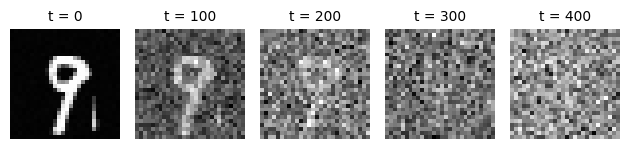

In [10]:
fig, axs = plt.subplots(1, len(time_steps))
for i, ax in enumerate(axs.flatten()):
	ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="gray")
	ax.set_title(f"t = {time_steps[i]}", fontsize=10)
	ax.axis("off")
plt.tight_layout()
plt.show()

## Text encoding

In this section, we will define the text encoding model that is used to convert text into embeddings. We will use the `CLIP` model for this purpose. The `CLIP` model is a vision-language model that learns to associate images and their textual descriptions. We will download the `CLIPTokenizer` and the `CLIPTextModel` from the `transformers` package.

A tokenizer is used to convert the input text into tokens, similar to giving a unique number in a dictionary to each word in the text. The text model is used to convert the tokens into embeddings.

In [11]:
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14", torch_dtype=torch.float32
)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14", torch_dtype=torch.float32
).to(device)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will check the tokens, and the embeddings for an example textual input. 

You will notice the each word of the text is assigned with a unique token, with the maximum length of the tokens being `77`. The tokens `49406` and `49407` are used to represent the start and the end of the text respectively. The embeddings are of the length `768`, where each word of the text is represented by a 768-dimensional vector.

In [12]:
# Example text
text_input = "Generate the image of number one"

# Tokenize the text
tokens = tokenizer(
    text_input, # Text input is passed through the tokenizer
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
print('tokens: ', tokens, '\n')
print('tokens shape:', tokens['input_ids'].shape, '\n')

# Pass the tokenized text through the text encoder
text_embedding = text_encoder(
    tokens.input_ids.to(device)
    )
print('text embeddings:', text_embedding[0].shape)

tokens:  {'input_ids': tensor([[49406, 16896,   518,  2867,   539,  2842,   637, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])} 

tokens shape: torch.Size([1, 77]) 

text embeddings: torch.Size([1, 77, 7

### Text prompts

We will define a list of text prompts that will be used to generate the images. Each text prompt in the list `mnist_train_prompts`, and `mnist_test_prompts` uses the class label of the MNIST dataset to generate the appropriate text prompt.

In [13]:
mnist_train_prompts = [
    "Generate the digit {class_label}.",
    "Create a sample of the number {class_label}.",
    "Show me a picture of the digit {class_label}.",
    "Produce the handwritten digit {class_label}.",
    "Please generate a grayscale image of the number {class_label}.",
    "Kindly create the digit {class_label} in a 28x28 resolution.",
    "I'd like to see the number {class_label} in bold font style.",
    "Show me the digit {class_label} in a slanted appearance.",
    "Generate the digit {class_label} with smooth curves.",
    "Create the number {class_label} with sharp edges.",
    "Show me an enhanced image of the digit {class_label}.",
    "Generate a blurry version of the digit {class_label}.",
    "Create an artistic representation of the number {class_label}.",
    "Show me the digit {class_label} as if drawn by a child.",
    "Generate the digit {class_label} with a serif font style.",
    "Create the number {class_label} with consistent stroke thickness.",
    "Show me the digit {class_label} in a tilted orientation.",
    "Generate the digit {class_label} with added noise.",
    "Create the number {class_label} using minimal strokes.",
    "Show me the digit {class_label} in a cursive font style.",
    "Please create a sketch of the number {class_label}.",
    "Show me a grayscale drawing of the digit {class_label}.",
    "Generate the digit {class_label} with a textured background.",
    "Create the number {class_label} in a monospaced font.",
    "Produce a simple version of the digit {class_label}.",
    "Generate an elegant image of the number {class_label}.",
    "Show me the digit {class_label} with embellishments.",
    "Create the number {class_label} with precise symmetry.",
    "Show me a modern representation of the digit {class_label}.",
    "Generate a futuristic version of the number {class_label}.",
    "Create the digit {class_label} with intricate details.",
    "Show me the number {class_label} in a retro style.",
    "Generate the digit {class_label} with artistic distortions.",
    "Create the number {class_label} with a shadow effect.",
    "Show me the digit {class_label} with vibrant colors.",
    "Generate the digit {class_label} with a 3D appearance.",
    "Create the number {class_label} with calligraphy strokes.",
    "Show me the digit {class_label} with embossed features.",
    "Generate the digit {class_label} with a pixelated look.",
    "Create the number {class_label} with fluid brush strokes.",
    "Show me the digit {class_label} with an abstract touch.",
    "Generate the digit {class_label} with pastel colors.",
    "Create the number {class_label} with a neon glow.",
    "Show me the digit {class_label} with a watercolor effect.",
    "Generate the digit {class_label} with a graffiti style.",
    "Create the number {class_label} with 8-bit pixel art.",
    "Show me the digit {class_label} with a mosaic pattern.",
    "Generate the digit {class_label} with a sketched appearance.",
    "Create the number {class_label} with a stained glass effect.",
    "Show me the digit {class_label} with a comic book style.",
    "Generate the digit {class_label} with a metallic sheen.",
]

mnist_test_prompts = [
    "Construct the numeral {class_label}.",
    "Formulate an exemplar of the numeral {class_label}.",
    "Display a depiction of the symbol {class_label}.",
    "Render the handwritten character {class_label}.",
    "Generate a grayscale depiction of the numeral {class_label}.",
    "Create the figure {class_label} in a 28x28 resolution.",
    "Exhibit the numeral {class_label} with bold typeface.",
    "Present the symbol {class_label} with a slanted tilt.",
    "Craft the numeral {class_label} using smooth curves.",
    "Design the digit {class_label} with distinct edges.",
    "Show an upgraded illustration of the digit {class_label}.",
    "Produce a hazy version of the digit {class_label}.",
    "Generate an imaginative rendering of the numeral {class_label}.",
    "Portray the digit {class_label} in a childlike manner.",
    "Draft the digit {class_label} with a typeface featuring serifs.",
    "Compose the number {class_label} with even line thickness.",
    "Exhibit the digit {class_label} at an inclined angle.",
    "Formulate the digit {class_label} with additional noise.",
    "Construct the number {class_label} using minimal lines.",
    "Craft the digit {class_label} in a script-like style.",
    "Construct a rough sketch of the numeral {class_label}.",
    "Provide a monochromatic drawing of the digit {class_label}.",
    "Generate the digit {class_label} with a textured backdrop.",
    "Create the numeral {class_label} using a uniform font.",
    "Render a simplified rendition of the digit {class_label}.",
    "Design an elegant portrayal of the number {class_label}.",
    "Display the digit {class_label} with ornamental accents.",
    "Craft the number {class_label} with precise mirror symmetry.",
    "Demonstrate a contemporary interpretation of the digit {class_label}.",
    "Generate a futuristic depiction of the number {class_label}.",
    "Create the digit {class_label} with intricate detailing.",
    "Portray the number {class_label} with a vintage touch.",
    "Construct the digit {class_label} with artistic distortion.",
    "Produce the number {class_label} with a shadowed effect.",
    "Present the digit {class_label} with vivid coloration.",
    "Generate the number {class_label} with a 3D effect.",
    "Create the digit {class_label} with calligraphic strokes.",
    "Exhibit the number {class_label} with embossed features.",
    "Design the digit {class_label} in a pixelated style.",
    "Render the number {class_label} with fluid brush strokes.",
    "Showcase the digit {class_label} with an abstract impression.",
    "Construct the digit {class_label} with soft pastel hues.",
    "Craft the number {class_label} with a neon luminance.",
    "Display the digit {class_label} with a watercolor appearance.",
    "Generate a digit {class_label} using graffiti-inspired style.",
    "Create the number {class_label} in an 8-bit pixel art format.",
    "Produce a digit {class_label} with a mosaic pattern.",
    "Render the digit {class_label} with a sketched effect.",
    "Design the number {class_label} with stained glass aesthetics.",
    "Present the digit {class_label} in a comic book style.",
    "Generate the digit {class_label} with a metallic shine.",
]

We will create helper function to convert the class labels from numeric form to textual form. We will use the `inflect` package to convert the numeric class labels to textual form and store them in the dictionary `mnist_mapping`.

In [14]:
import inflect

p = inflect.engine()
mnist_mapping = {i: p.number_to_words(i) for i in range(10)}
mnist_mapping

{0: 'zero',
 1: 'one',
 2: 'two',
 3: 'three',
 4: 'four',
 5: 'five',
 6: 'six',
 7: 'seven',
 8: 'eight',
 9: 'nine'}

We will create a helper function `generate_prompt` to take the class label as inputs and generate a random text prompt from the list of text prompts defined above. Additionally, we will also use the textual form of the class label in `70%` of the cases.

In [15]:
import random

def generate_prompt(class_label, mode="train"):
    if mode == "train":
        template_prompt = random.choice(mnist_train_prompts)
    elif mode == "test":
        template_prompt = random.choice(mnist_test_prompts)

    mapping = mnist_mapping

    if random.random() > 0.3: # 70% of the time, use the class label as a word
        prompt = template_prompt.format(class_label=mapping[class_label])
    else:
        prompt = template_prompt.format(class_label=str(class_label))
    return prompt

We will print some possible text prompts for the class label `5`.

In [16]:
# Define example class label
label = 5

# Print 10 text prompts for the class label
for _ in range(10):
    prompt = generate_prompt(label)
    print(prompt)

Show me a modern representation of the digit five.
Create an artistic representation of the number 5.
Show me the digit five in a cursive font style.
Create the digit five with intricate details.
Create the number five with consistent stroke thickness.
Produce the handwritten digit five.
Generate a blurry version of the digit five.
Generate the digit five with a metallic sheen.
Show me the digit five with embellishments.
Show me the digit five in a slanted appearance.


We will define the function `generate_batch_prompts` to generate a batch of text prompts for the given class labels. We will use the `generate_prompt` function to generate the text prompts for the given class labels. This function will be used to generate the text prompts in batches.

In [17]:
def generate_batch_prompts(class_labels, mode="train"):
    batch_prompts = []
    for label in class_labels:
        prompt = generate_prompt(label, mode=mode)
        batch_prompts.append(prompt)
    return batch_prompts

Print the batch of text prompts for a give list of class labels.

In [18]:
class_labels = [1, 2, 3, 4]
generate_batch_prompts(class_labels, mode="train")

['Show me the digit 1 with a watercolor effect.',
 'Please generate a grayscale image of the number two.',
 'Show me the digit three in a cursive font style.',
 'Show me a grayscale drawing of the digit four.']

## Attention UNet

In this section we will define the Attention UNet that is used in the DDPM model.

We use the class `AttentionUNet` from deeplay to define the Attention UNet architecture. It takes the noisy image and the time step corresponding to the noisy image as input, and returns the noise added to the image as output.

The input channels and output channels are defined the parameters `in_channels` and `out_channels` respectively. The `channels` parameter defines the number of channels in the hidden layers of the UNet, i.e., the number of convolutional filters in the hidden layers.

The `base_channels` parameter defines the number of channels at the base of the UNet, between the encoder and the decoder.

The `channel_attention` parameter can be used to control of attention mechanism that is applied at hidden channels. The boolean values (True or False) defined by the `channel_attention` parameter are used to control the attention mechanism. The first boolean value will be ignored as the time step attention is not included in the first hidden channel. When performing an ablation study, set the attention mechanism to `False` from the end of the list.

The `position_embedding_dim` parameter is used to indicate the dimension of the position encoding of the time step. We will look at it in more detail in the next step.

We will include an additional parameter `context_embedding_dim` for the text-to-image model. This parameter enables the model to take the context embedding of the input text as input.

In [19]:
import deeplay as dl

EMBEDDING_DIM = 256

model = dl.AttentionUNet(
    in_channels=1,
    channels=[32, 64, 128], # Since the image size is 28x28, we cannot use more than three channels
    base_channels=[256, 256],
    channel_attention=[True, True, True],
    position_embedding_dim=EMBEDDING_DIM,
    context_embedding_dim=768,
)
model.build()
model.to(device)

AttentionUNet(
  (encoder): UNetEncoder(
    (conv_block1): DoubleConvBlock(
      (blocks): LayerList(
        (0): Block(
          (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): GELU(approximate='none')
        )
        (1): Block(
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): Identity()
        )
      )
    )
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (conv_block): Sequential(
          (0): DoubleConvBlock(
            (blocks): LayerList(
              (0): Block(
                (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
                (activation): GELU(approximate='none')
              )
          

We will define the position encoding function, `positional_encoding` to convert the time step from a singular value to a position encoding vector. Instead of passing the time step as a singular value, we will pass it as a position encoding vector to the Attention UNet.

In [20]:
def positional_encoding(t, emb_dim):
	inv_freq = 1.0 / (10000 ** (torch.arange(0, emb_dim, 2).float() / emb_dim))
	inv_freq = inv_freq.to(t.device)
	pos_enc_a = torch.sin(t.repeat(1, emb_dim // 2) * inv_freq)
	pos_enc_b = torch.cos(t.repeat(1, emb_dim // 2) * inv_freq)
	pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
	return pos_enc

We now visualize the position encodings generated for different time steps. As we can see, the position encodings are different for different time steps. Each row in the plot corresponds to the position encoding for a time step.

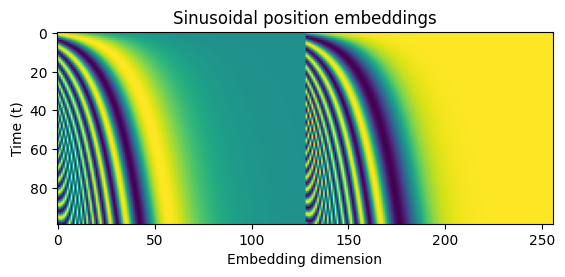

In [21]:
pos_encs = []

for i in range(1, 100):
	t = torch.tensor([i])
	pos_enc = positional_encoding(t, EMBEDDING_DIM)
	pos_encs.append(pos_enc.squeeze())

pos_encs = torch.stack(pos_encs)

fig = plt.figure()
plt.imshow(pos_encs.cpu().numpy())
plt.xlabel("Embedding dimension")
plt.ylabel("Time (t)")
plt.title("Sinusoidal position embeddings")
plt.show()

### Optimizers

We will define the optimizer and learning rate for the model. We will use the Adam optimizer with a learning rate of 1e-4.

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

### Loss function

We will use a mean squared error loss function to train the model.

In [23]:
criterion = torch.nn.MSELoss()

### Data loaders

We now define the data loaders for the training and val datasets. We will use a batch size of `128` as defined by the `batch_size` parameter. We will also set the `shuffle` parameter to `True` for the training data loader to shuffle the training dataset.

In [24]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=BATCH_SIZE, shuffle=True)

## Training procedure

We now define an instance of the `Diffusion` class with 1000 noise steps for training the model.

In [26]:
IMAGE_SIZE = 28
NOISE_STEPS = 1000

diffusion = Diffusion(img_size=IMAGE_SIZE, noise_steps=NOISE_STEPS, device=device)

We now define a helper function `prepare_data` to prepare the data for training the model. The function takes a clean image from the dataset, and returns the noisy image, time step, and the noise added to the image. The former two are used as input to the model, and the latter is used as the target output.

In [27]:
def prepare_data(image, device=device):
    
    # Generate noise and timesteps and apply diffusion
    batch_size = image.shape[0]
    t = diffusion.sample_timesteps(batch_size)
    image = image.to(device)
    x_t, noise = diffusion.noise_images(image, t)
    t = positional_encoding(t.unsqueeze(1), EMBEDDING_DIM) # Here unsqueeze required for broadcasting to the positional encoding (for parallel processing)

    # Move to device
    x_t = x_t.to(device)
    t = t.to(device)
    noise = noise.to(device)

    return x_t, t, noise

We now define the training loop for the DDPM model for generating MNIST digits from a noise image. We will train the model for 20 epochs defined by the `EPOCHS` parameter.

Once every epoch, we will print the losses, time taken for the epoch, and also visualize the generated images.



Epoch 1 / 20
__________


Batch 1 / 469: Train loss: 1.2468
Batch 101 / 469: Train loss: 0.1114
Batch 201 / 469: Train loss: 0.0867
Batch 301 / 469: Train loss: 0.0679
Batch 401 / 469: Train loss: 0.0695
----------
Epoch 1/20 : Train loss: 0.1205, Val loss: 0.0551
Time taken: 0:03:54.671542


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 56.99it/s]


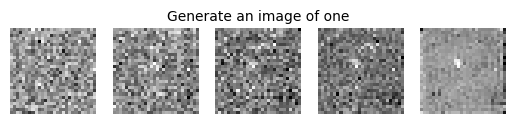

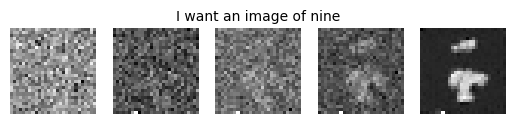

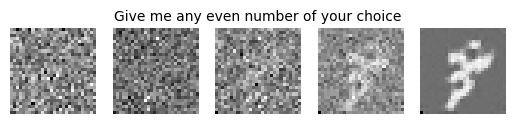

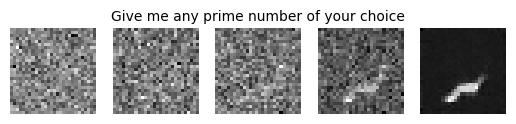



Epoch 2 / 20
__________
Batch 1 / 469: Train loss: 0.0544
Batch 101 / 469: Train loss: 0.0485
Batch 201 / 469: Train loss: 0.0365
Batch 301 / 469: Train loss: 0.0502
Batch 401 / 469: Train loss: 0.0406
----------
Epoch 2/20 : Train loss: 0.0467, Val loss: 0.0427
Time taken: 0:03:57.977877


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 56.63it/s]


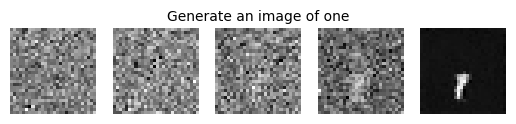

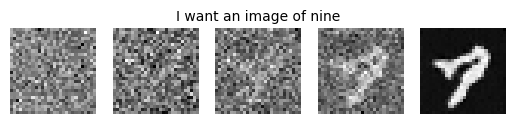

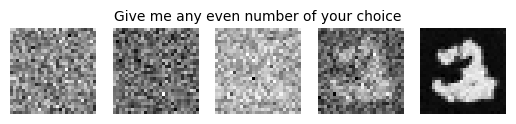

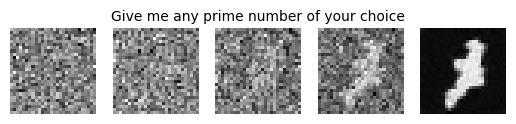



Epoch 3 / 20
__________
Batch 1 / 469: Train loss: 0.0432
Batch 101 / 469: Train loss: 0.0427
Batch 201 / 469: Train loss: 0.0433
Batch 301 / 469: Train loss: 0.0494
Batch 401 / 469: Train loss: 0.0379
----------
Epoch 3/20 : Train loss: 0.0386, Val loss: 0.0365
Time taken: 0:03:58.386991


UNet inference: 100%|██████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:09<00:00, 102.61it/s]


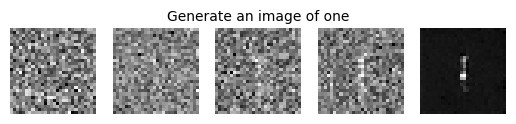

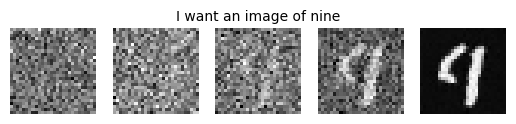

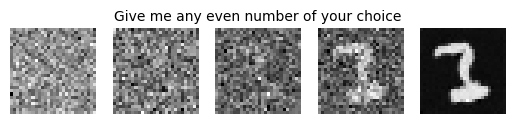

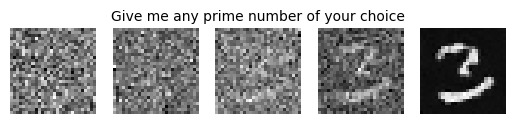



Epoch 4 / 20
__________
Batch 1 / 469: Train loss: 0.0305
Batch 101 / 469: Train loss: 0.0346
Batch 201 / 469: Train loss: 0.0322
Batch 301 / 469: Train loss: 0.0349
Batch 401 / 469: Train loss: 0.0305
----------
Epoch 4/20 : Train loss: 0.0345, Val loss: 0.0340
Time taken: 0:03:57.994680


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 57.49it/s]


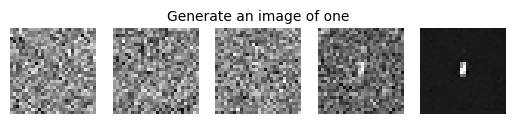

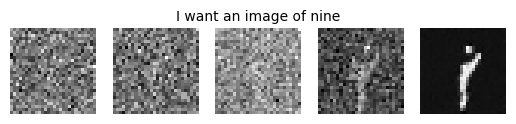

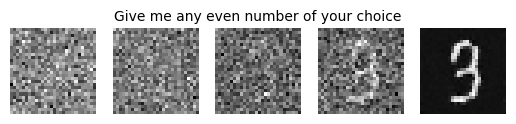

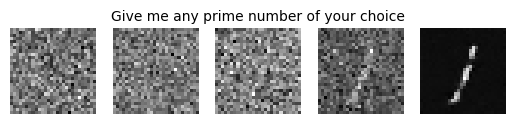



Epoch 5 / 20
__________
Batch 1 / 469: Train loss: 0.0331
Batch 101 / 469: Train loss: 0.0268
Batch 201 / 469: Train loss: 0.0341
Batch 301 / 469: Train loss: 0.0263
Batch 401 / 469: Train loss: 0.0358
----------
Epoch 5/20 : Train loss: 0.0317, Val loss: 0.0324
Time taken: 0:04:00.879293


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 56.48it/s]


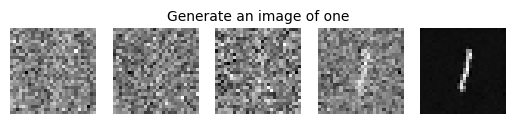

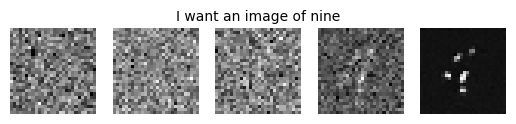

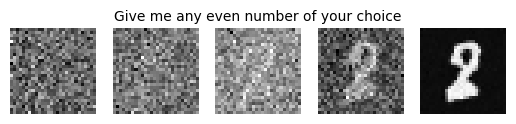

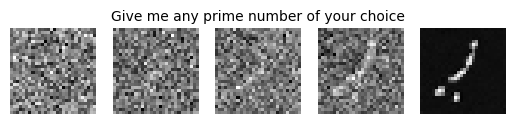



Epoch 6 / 20
__________
Batch 1 / 469: Train loss: 0.0292
Batch 101 / 469: Train loss: 0.0386
Batch 201 / 469: Train loss: 0.0369
Batch 301 / 469: Train loss: 0.0334
Batch 401 / 469: Train loss: 0.0309
----------
Epoch 6/20 : Train loss: 0.0303, Val loss: 0.0291
Time taken: 0:03:59.771388


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:11<00:00, 88.29it/s]


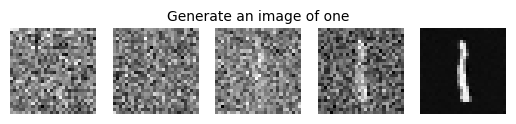

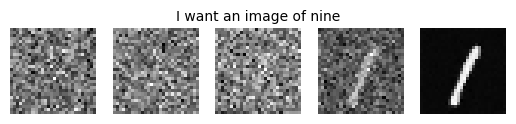

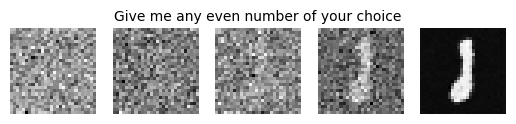

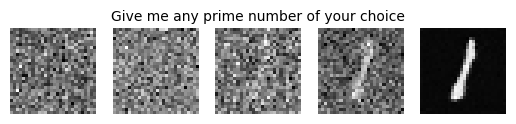



Epoch 7 / 20
__________
Batch 1 / 469: Train loss: 0.0280
Batch 101 / 469: Train loss: 0.0294
Batch 201 / 469: Train loss: 0.0236
Batch 301 / 469: Train loss: 0.0326
Batch 401 / 469: Train loss: 0.0257
----------
Epoch 7/20 : Train loss: 0.0286, Val loss: 0.0286
Time taken: 0:03:53.301891


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:14<00:00, 68.59it/s]


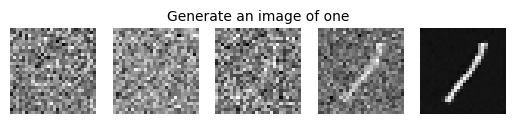

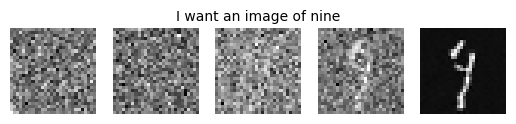

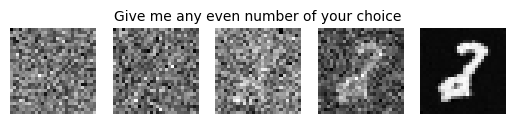

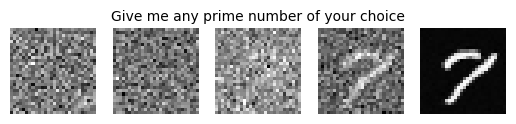



Epoch 8 / 20
__________
Batch 1 / 469: Train loss: 0.0222
Batch 101 / 469: Train loss: 0.0267
Batch 201 / 469: Train loss: 0.0239
Batch 301 / 469: Train loss: 0.0338
Batch 401 / 469: Train loss: 0.0345
----------
Epoch 8/20 : Train loss: 0.0278, Val loss: 0.0274
Time taken: 0:03:54.743090


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 56.21it/s]


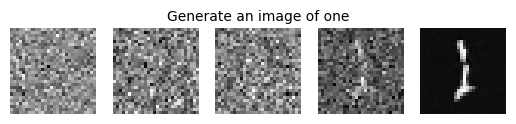

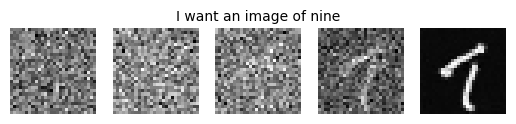

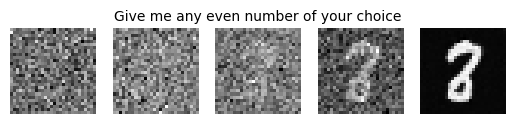

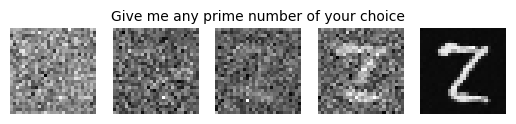



Epoch 9 / 20
__________
Batch 1 / 469: Train loss: 0.0315
Batch 101 / 469: Train loss: 0.0277
Batch 201 / 469: Train loss: 0.0246
Batch 301 / 469: Train loss: 0.0248
Batch 401 / 469: Train loss: 0.0267
----------
Epoch 9/20 : Train loss: 0.0275, Val loss: 0.0279
Time taken: 0:03:54.581676


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 56.68it/s]


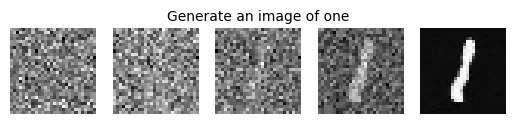

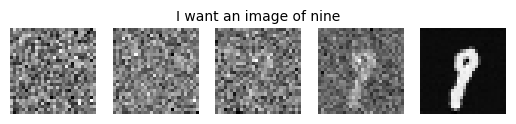

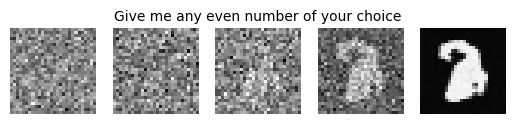

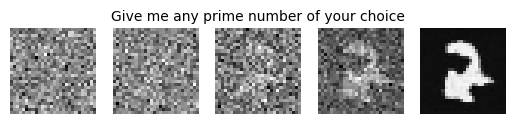



Epoch 10 / 20
__________
Batch 1 / 469: Train loss: 0.0240
Batch 101 / 469: Train loss: 0.0291
Batch 201 / 469: Train loss: 0.0224
Batch 301 / 469: Train loss: 0.0284
Batch 401 / 469: Train loss: 0.0267
----------
Epoch 10/20 : Train loss: 0.0263, Val loss: 0.0274
Time taken: 0:03:56.043799


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:10<00:00, 99.25it/s]


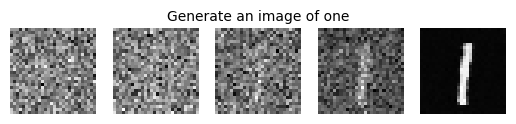

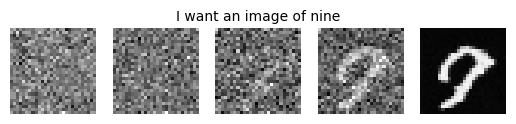

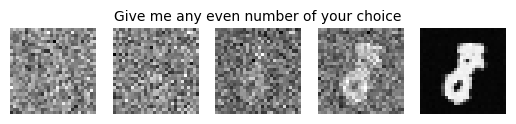

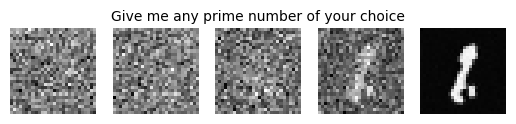



Epoch 11 / 20
__________
Batch 1 / 469: Train loss: 0.0243
Batch 101 / 469: Train loss: 0.0247
Batch 201 / 469: Train loss: 0.0286
Batch 301 / 469: Train loss: 0.0298
Batch 401 / 469: Train loss: 0.0338
----------
Epoch 11/20 : Train loss: 0.0260, Val loss: 0.0256
Time taken: 0:03:57.764480


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 56.76it/s]


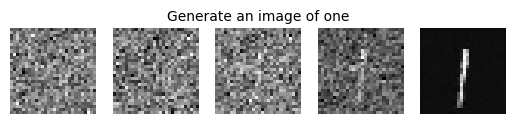

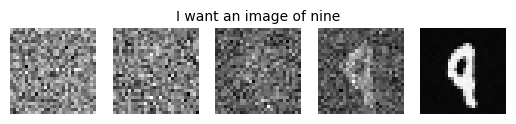

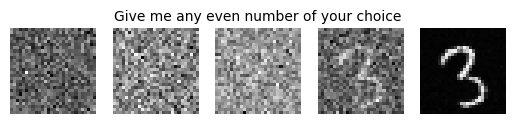

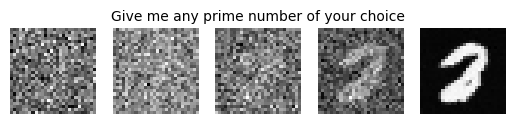



Epoch 12 / 20
__________
Batch 1 / 469: Train loss: 0.0273
Batch 101 / 469: Train loss: 0.0254
Batch 201 / 469: Train loss: 0.0240
Batch 301 / 469: Train loss: 0.0309
Batch 401 / 469: Train loss: 0.0262
----------
Epoch 12/20 : Train loss: 0.0258, Val loss: 0.0268
Time taken: 0:04:00.224725


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 56.37it/s]


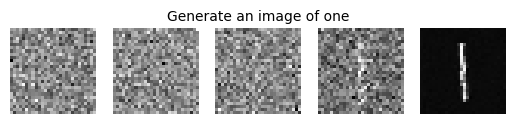

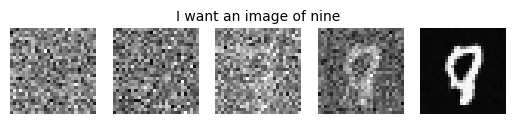

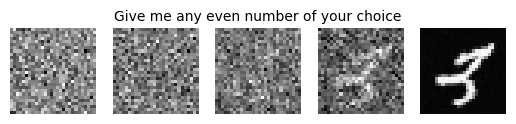

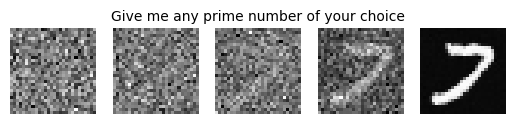



Epoch 13 / 20
__________
Batch 1 / 469: Train loss: 0.0193
Batch 101 / 469: Train loss: 0.0254
Batch 201 / 469: Train loss: 0.0203
Batch 301 / 469: Train loss: 0.0286
Batch 401 / 469: Train loss: 0.0262
----------
Epoch 13/20 : Train loss: 0.0252, Val loss: 0.0257
Time taken: 0:03:57.525719


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:12<00:00, 80.94it/s]


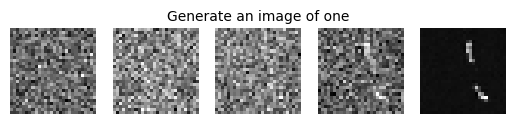

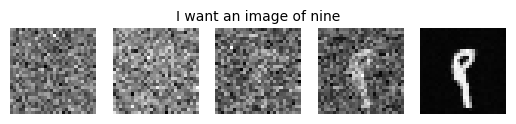

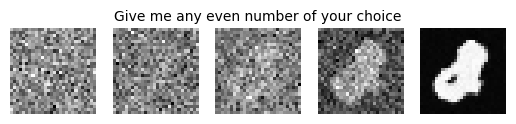

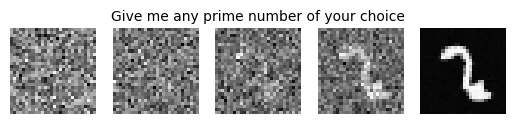



Epoch 14 / 20
__________
Batch 1 / 469: Train loss: 0.0273
Batch 101 / 469: Train loss: 0.0236
Batch 201 / 469: Train loss: 0.0224
Batch 301 / 469: Train loss: 0.0293
Batch 401 / 469: Train loss: 0.0259
----------
Epoch 14/20 : Train loss: 0.0249, Val loss: 0.0249
Time taken: 0:03:52.603573


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:14<00:00, 69.80it/s]


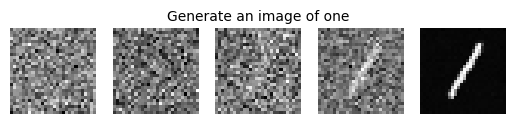

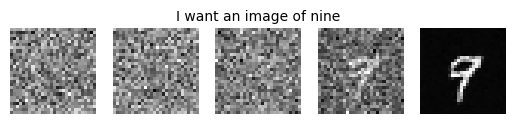

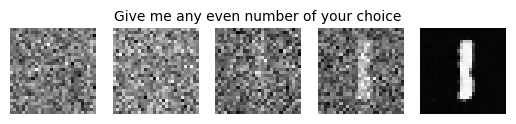

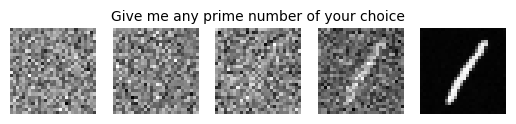



Epoch 15 / 20
__________
Batch 1 / 469: Train loss: 0.0321
Batch 101 / 469: Train loss: 0.0285
Batch 201 / 469: Train loss: 0.0257
Batch 301 / 469: Train loss: 0.0222
Batch 401 / 469: Train loss: 0.0225
----------
Epoch 15/20 : Train loss: 0.0249, Val loss: 0.0251
Time taken: 0:03:56.255969


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 57.15it/s]


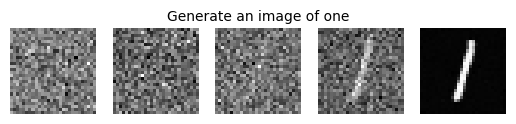

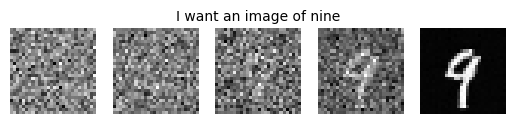

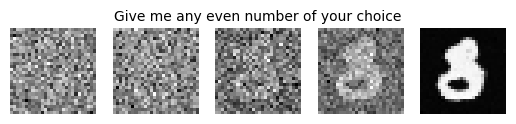

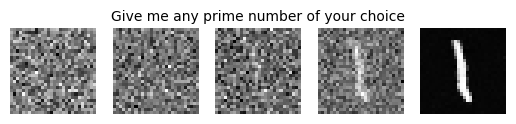



Epoch 16 / 20
__________
Batch 1 / 469: Train loss: 0.0271
Batch 101 / 469: Train loss: 0.0251
Batch 201 / 469: Train loss: 0.0217
Batch 301 / 469: Train loss: 0.0251
Batch 401 / 469: Train loss: 0.0301
----------
Epoch 16/20 : Train loss: 0.0243, Val loss: 0.0248
Time taken: 0:03:55.127460


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 56.72it/s]


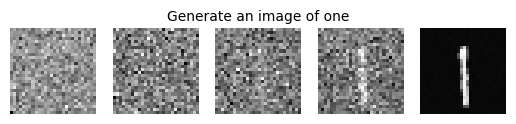

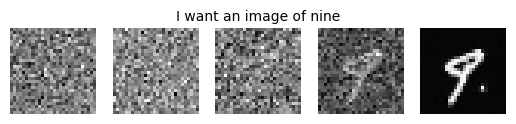

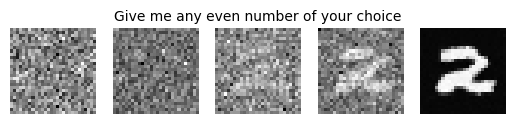

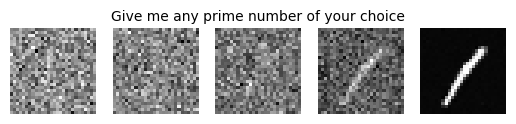



Epoch 17 / 20
__________
Batch 1 / 469: Train loss: 0.0209
Batch 101 / 469: Train loss: 0.0180
Batch 201 / 469: Train loss: 0.0260
Batch 301 / 469: Train loss: 0.0255
Batch 401 / 469: Train loss: 0.0254
----------
Epoch 17/20 : Train loss: 0.0242, Val loss: 0.0257
Time taken: 0:03:55.173270


UNet inference: 100%|██████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:09<00:00, 100.35it/s]


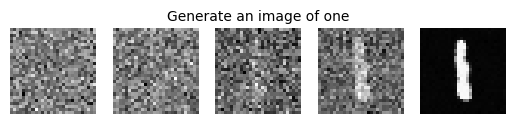

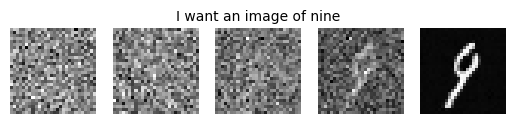

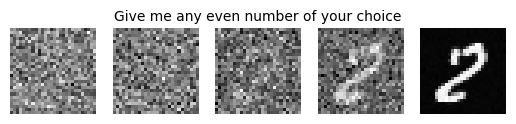

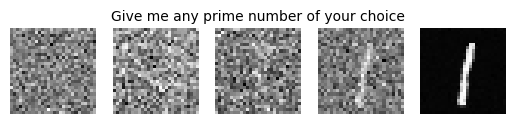



Epoch 18 / 20
__________
Batch 1 / 469: Train loss: 0.0240
Batch 101 / 469: Train loss: 0.0232
Batch 201 / 469: Train loss: 0.0215
Batch 301 / 469: Train loss: 0.0228
Batch 401 / 469: Train loss: 0.0206
----------
Epoch 18/20 : Train loss: 0.0242, Val loss: 0.0244
Time taken: 0:03:55.891178


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 56.76it/s]


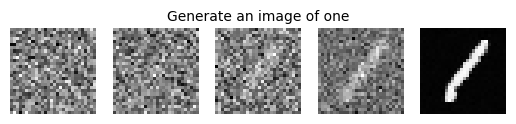

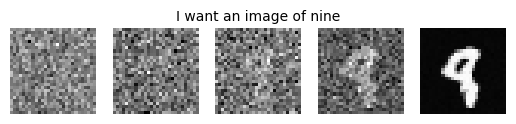

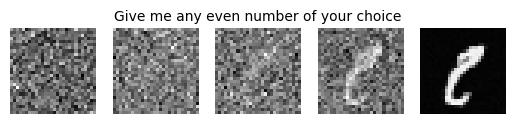

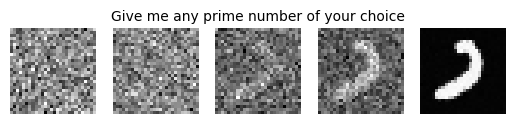



Epoch 19 / 20
__________
Batch 1 / 469: Train loss: 0.0275
Batch 101 / 469: Train loss: 0.0277
Batch 201 / 469: Train loss: 0.0253
Batch 301 / 469: Train loss: 0.0203
Batch 401 / 469: Train loss: 0.0207
----------
Epoch 19/20 : Train loss: 0.0236, Val loss: 0.0231
Time taken: 0:03:55.038204


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:17<00:00, 56.91it/s]


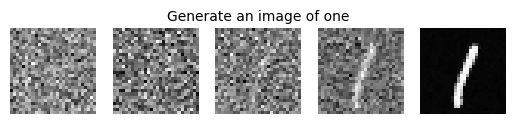

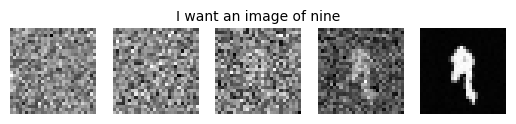

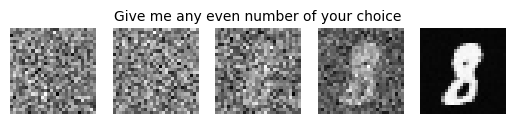

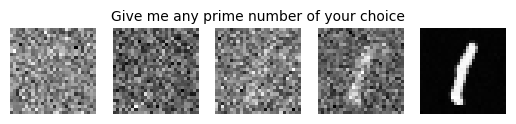



Epoch 20 / 20
__________
Batch 1 / 469: Train loss: 0.0210
Batch 101 / 469: Train loss: 0.0212
Batch 201 / 469: Train loss: 0.0222
Batch 301 / 469: Train loss: 0.0252
Batch 401 / 469: Train loss: 0.0251
----------
Epoch 20/20 : Train loss: 0.0236, Val loss: 0.0238
Time taken: 0:03:57.663683


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:14<00:00, 69.99it/s]


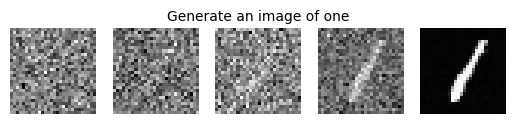

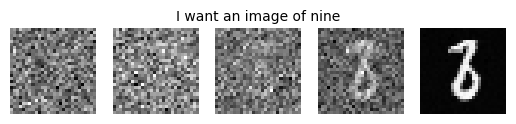

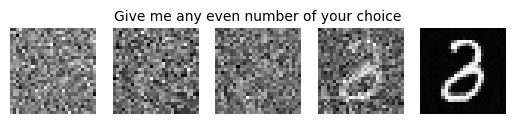

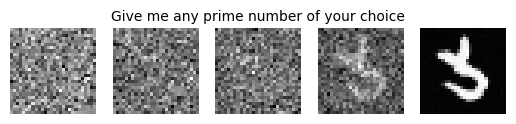

In [28]:
EPOCHS = 20

# Import the packages required for checking the time taken for each epoch
import time
from datetime import timedelta

# Create lists to store the training and validation loss
train_loss = []
val_loss = []

for epoch in range(EPOCHS):

    # Record the start time of the epoch
    start_time = time.time()    

    num_batches = len(train_loader)

    print("\n")
    print(f"Epoch {epoch+1} / {EPOCHS}")
    print("_" * 10)

    model.train(True)

    running_loss = 0.0
    for batch_idx, (image, class_labels) in enumerate(train_loader, start=0):

        # Prepare data
        x_t, t, noise = prepare_data(image)

        # Prepare text prompts and text embeddings
        text_prompts = generate_batch_prompts(
            class_labels.numpy(), mode="train"
        )

        # Pass the text prompts through the tokenizer
        tokens = tokenizer(
            text_prompts,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )

        # Pass the tokenized text through the text encoder
        text_embeddings = text_encoder(tokens.input_ids.to(device))

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + reverse + gradients
        outputs = model(x_t, t, y=None, context=text_embeddings[0])
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()

        # Print loss after certian number of batches
        if batch_idx % 100 == 0:
            print(
                f"Batch {batch_idx+1} / {num_batches}: Train loss: {loss.item():.4f}"
            )

        # Update the running loss
        running_loss += loss.item()

    # Store the training loss for this epoch
    train_loss.append(running_loss / len(train_loader))

    # Validation
    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        for batch_idx, (image, class_labels) in enumerate(val_loader):
            # Prepare data
            x_t, t, noise = prepare_data(image)

            text_prompts = generate_batch_prompts(
                class_labels.numpy(), mode="test"
            )

            tokens = tokenizer(
                text_prompts,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )

            text_embeddings = text_encoder(tokens.input_ids.to(device))

            # Forward pass
            outputs = model(x_t, t, y=None, context=text_embeddings[0])
            loss = criterion(outputs, noise)

            # Update the running loss
            running_loss += loss.item()

        # Store the validation loss for this epoch
        val_loss.append(running_loss / len(val_loader))

    # Record the end time of the epoch
    end_time = time.time()

    # Print the loss for this epoch
    print("-" * 10)
    print(
        f"Epoch {epoch+1}/{EPOCHS} : Train loss: {train_loss[-1]:.4f}, Val loss: {val_loss[-1]:.4f}"
    )
    print(f"Time taken: {timedelta(seconds=end_time - start_time)}")

    # Generate some images from noise every epoch
    prompts = [
        "Generate an image of one",
        "I want an image of nine",
        "Give me any even number of your choice",
        "Give me any prime number of your choice",
    ]

    tokens = tokenizer(
        prompts,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_embeddings = text_encoder(tokens.input_ids.to(device))

    generated_images = diffusion.sample_test_images(
        model,
        n=len(prompts),
        n_channels=1,
        position_encoding_dim=EMBEDDING_DIM,
        position_encoding_function=positional_encoding,
        context=text_embeddings[0],
        save_every=200,
    )

    def denormalize_noise(image):
        image = image.permute(1, 2, 0).cpu().numpy()
        image = image * 0.5 + 0.5
        return image


    for i in range(generated_images.shape[0]):
        fig, axs = plt.subplots(1, 5)
        axs[2].set_title(prompts[i], loc="center", fontsize=10)
        for j in range(5):
            axs[j].imshow(denormalize_noise(generated_images[i, j]), cmap="gray")
            axs[j].axis("off")
        plt.show()


### Sample images

Using the trained model, we will now generate some images from the text prompts.

UNet inference:   1%|█                                                                            | 14/1000 [00:00<00:14, 66.08it/s]

UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:10<00:00, 91.10it/s]


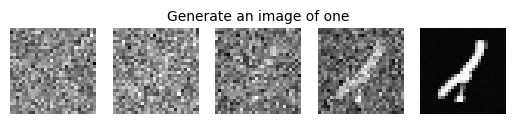

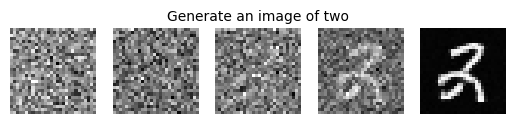

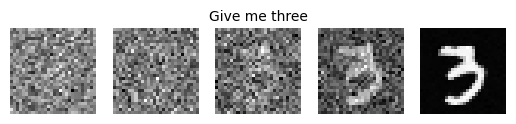

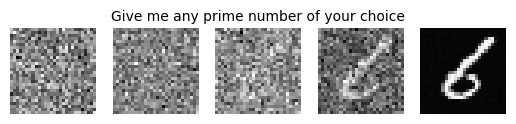

In [29]:
from tqdm import tqdm

# Generate some images from noise every epoch
prompts = [
    "Generate an image of one",
    "Generate an image of two",
    "Give me three",
    "Give me any prime number of your choice",
]

tokens = tokenizer(
    prompts,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

text_embeddings = text_encoder(tokens.input_ids.to(device))

generated_images = diffusion.sample_test_images(
    model,
    n=4,
    n_channels=1,
    position_encoding_dim=EMBEDDING_DIM,
    position_encoding_function=positional_encoding,
    context=text_embeddings[0],
    save_every=200,
)

def denormalize_noise(image):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = image * 0.5 + 0.5
    # image = 1 - image
    return image


for i in range(generated_images.shape[0]):
    fig, axs = plt.subplots(1, 5)
    axs[2].set_title(prompts[i], loc="center", fontsize=10)
    for j in range(5):
        axs[j].imshow(denormalize_noise(generated_images[i, j]), cmap="gray")
        axs[j].axis("off")
    plt.show()

### Plot losses

We now plot the losses for the training and test datasets.

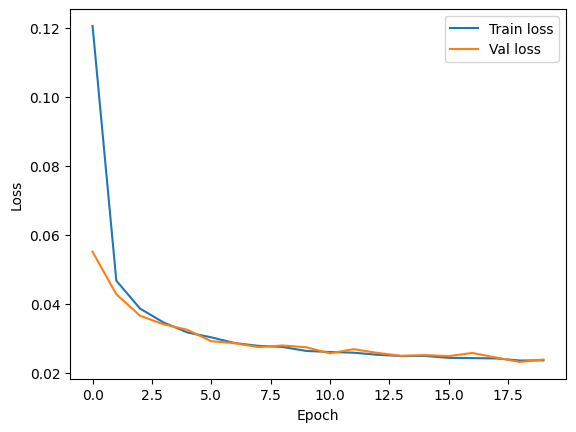

In [30]:
plt.plot(train_loss, label="Train loss")
plt.plot(val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()